In [ ]:
Лабораторна робота 3. Варіант 3. Євдокимов Олексій

In [31]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
from matplotlib import image as img

warnings.filterwarnings('ignore')


%matplotlib inline

In [32]:
MAIN_TAG = 'nikon'
DIRNAME_TAGS = 'E:/Labs/tags'
DIRNAME_IMAGES = 'E:/Labs/mirflickr'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [33]:
# 1.generate a test sample of images from the source package

np.random.RandomState(3)
sample_size = 250
indexes = np.random.choice(range(25000), sample_size)
images = list()
for i in range(sample_size):
    filename = 'im' + str(indexes[i]) + '.jpg'
    img_data = img.imread('E:/Labs/mirflickr/' + filename)
    images.append(img_data)

print(f'{sample_size} images uploaded, processing begins...')

values = np.zeros((3, 256))
for image in images:
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            values[0][image[i][j][0]] += 1
            values[1][image[i][j][1]] += 1
            values[2][image[i][j][2]] += 1
            
print('all images processed')

250 images uploaded, processing begins...
all images processed


In [34]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [35]:
Y['target'].value_counts()

0    242
1      8
Name: target, dtype: int64

In [36]:
Y.head()

,target
1115,0
2005,0
15402,0
17794,0
8490,0


In [37]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [38]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
1115,145.716258,5245.566175,-0.516526,-0.598343,122.413580,5198.605859,-0.109227,-0.818177,102.539399,4879.242045,0.437974,-0.557680
2005,49.025163,3071.202036,1.433315,1.567194,43.373753,2720.277315,1.585288,2.149267,35.824277,2045.468627,1.941546,4.173040
15402,161.894584,2733.691978,0.049956,-0.769068,138.170807,3320.861982,0.279099,-0.437544,118.606235,3976.688798,0.382372,-0.442355
17794,62.899973,4178.389221,1.516380,1.607255,68.541387,4258.000554,1.316090,1.127021,73.435744,3601.294522,1.202903,1.087438
8490,109.274708,3426.381020,-0.679336,-0.993543,82.706564,2206.571259,-0.425561,-1.222114,49.943424,1288.853975,-0.133092,-1.359322


In [39]:
data_static.shape

(250, 12)

In [40]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [41]:
N = 12

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

In [ ]:
STATIC

In [43]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.98350515 0.01649485]
 [1.         0.        ]]


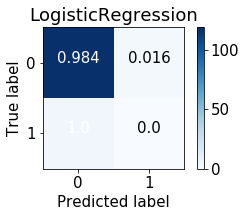

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


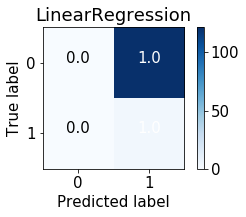

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


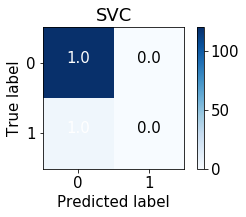

In [44]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()

In [ ]:
SPAM

Normalized confusion matrix
[[0.99861496 0.00138504]
 [1.         0.        ]]


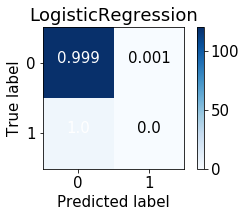

[[120.16666667   0.16666667]
 [  4.66666667   0.        ]]
Normalized confusion matrix
[[0.99656829 0.00343171]
 [1.         0.        ]]


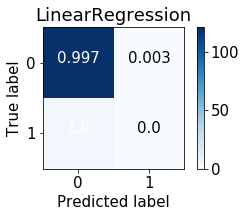

[[121.           0.41666667]
 [  3.58333333   0.        ]]
Normalized confusion matrix
[[0.99793103 0.00206897]
 [1.         0.        ]]


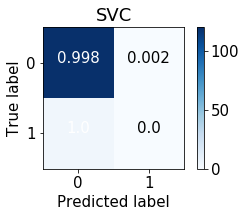

[[120.58333333   0.25      ]
 [  4.16666667   0.        ]]


In [45]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

In [ ]:
CCPEV

Normalized confusion matrix
[[0.98551724 0.01448276]
 [1.         0.        ]]


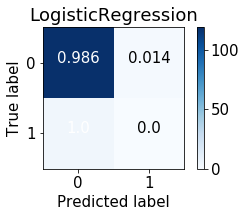

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


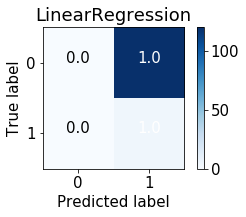

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


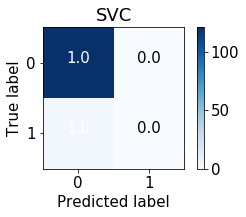

In [46]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)